In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

Load h5ad (corrected expression with metadata). Slots include
- logarithmized data in adata.X
- pearson residuals from the SCTransform correction procedure, in the scale.data slot

In [3]:
adata = sc.read_h5ad("seurat.sctransformed.h5ad")

We want to work with the pearson residuals 

In [4]:
adata.layers['log.data'] = adata.X
adata.X = adata.layers['scale.data']

SCTransform doesn't actually enforce that all genes have unit variance, but we want this to be the case, so we have to include a scaling step

In [5]:
sc.pp.scale(adata)
sc.pp.pca(adata)

Visualize the PCs, and note that the third PC is picking up on variation very specifically driven by cluster 6

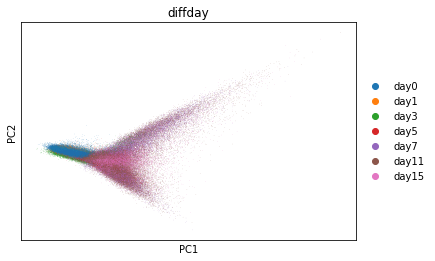

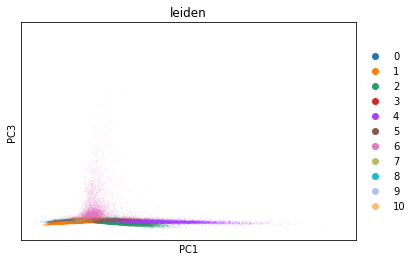

In [10]:
sc.pl.pca(adata, color="diffday")
sc.pl.pca(adata, color="leiden", components=[1,3])

The first PC seems to pick up on progression through differentiation

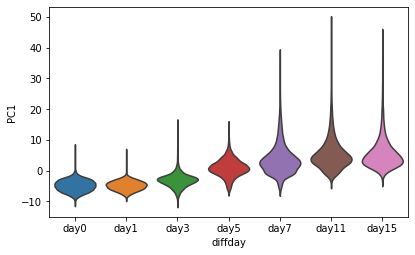

In [42]:
adata.obs['PC1'] = adata.obsm['X_pca'][:,0]
sc.pl.violin(adata, keys="PC1", groupby="diffday", size=0)

In [7]:
sc.pp.neighbors(adata, n_neighbors=30)

/home-2/jpopp4@jhu.edu/.local/lib/python3.8/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets
/home-2/jpopp4@jhu.edu/.local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10004. The TBB threading layer is disabled.
  warnings.warn(problem)


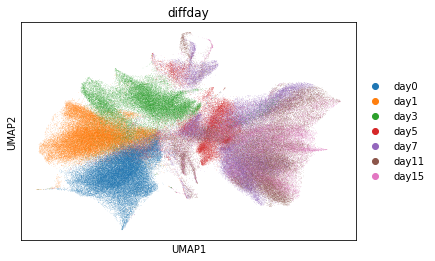

In [8]:
sc.tl.umap(adata)
sc.pl.umap(adata, color="diffday")

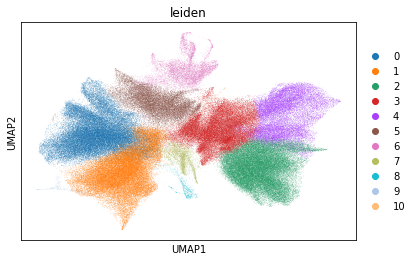

In [9]:
sc.tl.leiden(adata, resolution=0.45)
sc.pl.umap(adata, color="leiden")

In [11]:
sc.tl.diffmap(adata)

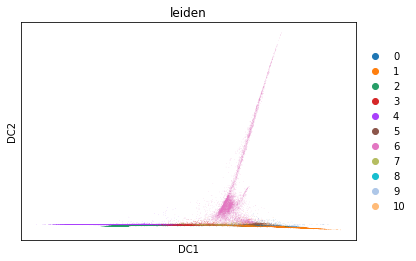

In [12]:
sc.pl.diffmap(adata, color='leiden')

In [13]:
adata.write_h5ad("scanpy.clustered.h5ad")

Cluster 6 appears to express endoderm marker genes, these do not look like cardiomyocytes or other heart-related cells. We remove this cluster, as well as other smaller clusters of cells, for downstream analysis so that we can focus on the heart-related cell types

In [17]:
adata_cardiac = adata[adata.obs['leiden'].isin(['0', '1', '2', '3', '4', '5'])]

/home-2/jpopp4@jhu.edu/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [18]:
def leiden2type(l):
    if l == '1':
        return 'IPSC'
    elif l == '0':
        return "MES"
    elif l == '5':
        return "CMES"
    elif l == '3':
        return "PROG"
    elif l == '4':
        return "CF"
    elif l == '2':
        return "CM"

In [19]:
adata_cardiac.obs['type'] = [leiden2type(lei) for lei in adata_cardiac.obs['leiden']]

Trying to set attribute `.obs` of view, copying.


/home-2/jpopp4@jhu.edu/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'type' as categorical


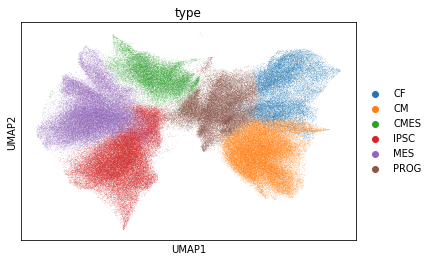

In [20]:
sc.pl.umap(adata_cardiac, color='type')

Since these are a different group of cells, we need to rescale and rerun pca

In [ ]:
sc.pp.scale(adata_cardiac)
sc.pp.pca(adata_cardiac)

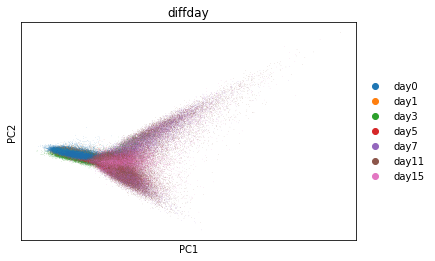

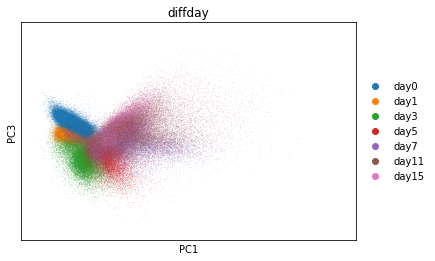

In [40]:
sc.pl.pca(adata_cardiac, color="diffday")
sc.pl.pca(adata_cardiac, components=[1,3], color="diffday")

Recompute the neighborhood graph, and obtain diffusion components based on this graph. These can be interpreted as denoised principal components

In [22]:
sc.pp.neighbors(adata_cardiac, n_pcs=3)

/home-2/jpopp4@jhu.edu/.local/lib/python3.8/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets
/home-2/jpopp4@jhu.edu/.local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10004. The TBB threading layer is disabled.
  warnings.warn(problem)


In [23]:
sc.tl.diffmap(adata_cardiac, n_comps=4)

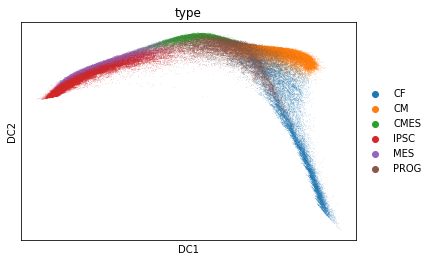

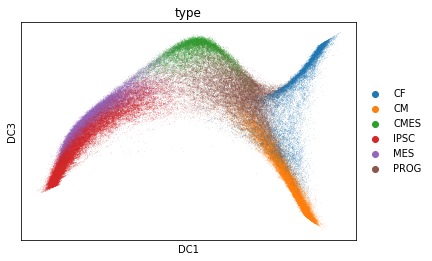

In [25]:
sc.pl.diffmap(adata_cardiac, color='type')
sc.pl.diffmap(adata_cardiac, components=[1,3], color='type')

PAGA gives us a look at the relationship between clusters, which (along with marker gene expression) allows us to understand the trajectories that are present in our data

In [26]:
sc.tl.paga(adata_cardiac, groups='type')

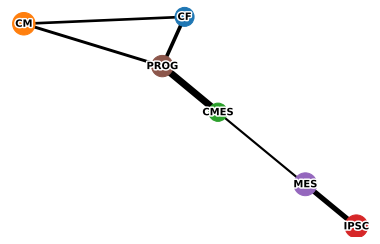

In [4]:
sc.pl.paga(adata_cardiac, threshold=0.15, 
           fontoutline=3, node_size_scale=3, frameon=False)

Perform pseudotime inference using diffusion pseudotime; the root will be in the iPSC cluster

In [19]:
adata_cardiac.uns['iroot'] = np.flatnonzero(adata_cardiac.obs['type']  == 'IPSC')[0]
sc.tl.dpt(adata_cardiac, n_dcs=3)

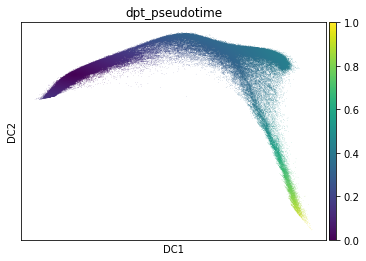

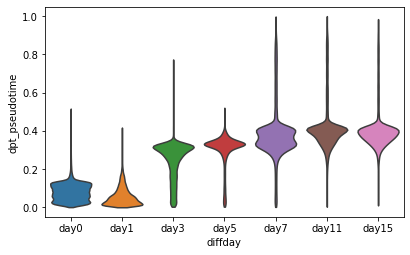

In [20]:
sc.pl.diffmap(adata_cardiac, color='dpt_pseudotime')
sc.pl.violin(adata_cardiac, keys="dpt_pseudotime", groupby="diffday", size=0)

In [21]:
adata_cardiac.write_h5ad("scanpy.pseudotime.h5ad")